#  SPE DSEATS Africa Datathon 2025 - Well Classification

This notebook classifies 20 oil wells and estimates total oil production per reservoir using provided datasets.

## Objective
- Classify 20 wells by:
  - Reservoir Name
  - Reservoir Type (Saturated/Undersaturated)
  - Well Type (NF/GL)
  - Production Type (Steady/Unsteady)
  - GOR Trend (aSolGOR/bSolGOR/Combo)
  - Watercut Trend (Flat/Incr/Decr/Combo)
  - Oil PI Trend (Flat/Incr/Decr/Combo)
- Estimate total oil production (reservoir barrels) for five reservoirs (ACHI, KEMA, MAKO, DEPU, JANI)

## Workflow

-  Project Introduction & Objective
-  Import Libraries & Load Data
-  Data Cleaning & Preprocessing
-  Exploratory Data Analysis (EDA)
-  Feature Engineering (Watercut, GOR, PI)
-  Classify Wells Using Logic Rules
-  (Optional) Automate with ML Models
-  Export Classification File & Prepare Slides

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')
import joblib

# Set visual theme
sns.set_style("darkgrid")  
sns.set_palette("Set2")

In [2]:
# Load datasets
well_df = pd.read_csv("C:/Users/osuol/Desktop/SPE DSEAT/spe_africa_dseats_datathon_2025_wells_dataset.csv")
reservoir_df = pd.read_csv("C:/Users/osuol/Desktop/SPE DSEAT/reservoir_info.csv")

# Display shape and columns
well_df.head()

,PROD_DATE,WELL_NAME,ON_STREAM_HRS,BOTTOMHOLE_FLOWING_PRESSURE (PSI),DOWNHOLE_TEMPERATURE (deg F),ANNULUS_PRESS (PSI),CHOKE_SIZE (%),WELL_HEAD_PRESSURE (PSI),WELL_HEAD_TEMPERATURE (deg F),CUMULATIVE_OIL_PROD (STB),CUMULATIVE_FORMATION_GAS_PROD (MSCF),CUMULATIVE_TOTAL_GAS_PROD (MSCF),CUMULATIVE_WATER_PROD (BBL)
0,15-Feb-14,Well_#1,0.0,"4,050",189.866,0,1.17951,482.46,50.864,0,0,0,0
1,16-Feb-14,Well_#1,0.0,"3,961",189.945,0,2.99440,328.601,47.668,0,0,0,0
2,17-Feb-14,Well_#1,0.0,"3,961",190.004,0,1.90349,387.218,48.962,0,0,0,0
3,18-Feb-14,Well_#1,0.0,"3,964",190.020,0,0.00000,308.98,46.636,0,0,0,0
4,19-Feb-14,Well_#1,0.0,"3,965",190.107,0,30.20760,196.057,47.297,0,0,0,0


In [3]:
well_df.shape

(7955, 13)

In [4]:
well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7955 entries, 0 to 7954
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   PROD_DATE                             7955 non-null   object 
 1   WELL_NAME                             7955 non-null   object 
 2   ON_STREAM_HRS                         7955 non-null   float64
 3   BOTTOMHOLE_FLOWING_PRESSURE (PSI)     7955 non-null   object 
 4   DOWNHOLE_TEMPERATURE (deg F)          7955 non-null   float64
 5   ANNULUS_PRESS (PSI)                   7955 non-null   object 
 6   CHOKE_SIZE (%)                        7955 non-null   float64
 7   WELL_HEAD_PRESSURE (PSI)              7955 non-null   object 
 8   WELL_HEAD_TEMPERATURE (deg F)         7955 non-null   float64
 9   CUMULATIVE_OIL_PROD (STB)             7955 non-null   object 
 10  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  7955 non-null   object 
 11  CUMULATIVE_TOTAL_

In [5]:
reservoir_df

,Reservoir Name,Initial Reservoir Pressure (PSI),Bubble Point Pressure (PSI),Current Average Reservoir Pressure (PSI),Solution Gas-Oil-Ratio (SCF/BBL),Formation Volume Factor (RB/STB)
0,ACHI,"3,500","3,300","2,700",800,1.20
1,KEMA,"4,200","4,000","3,900",600,1.45
2,MAKO,"3,500","3,500","3,000",500,1.15
3,DEPU,"2,800","2,800","2,400","1,200",1.37
4,JANI,"4,500","4,300","4,200","1,000",1.30


I noticed that some columns with numbers like pressures and production volumes are showing as `object` instead of numeric. This is likely because of comma separators.

I'll fix that by removing the commas and convert them to float so I can work with them properly later on.

In [6]:
# Convert PROD_DATE to datetime
well_df['PROD_DATE'] = pd.to_datetime(well_df['PROD_DATE'], format='%d-%b-%y')

In [7]:
# Removing commas,and converting to float
cols_to_clean = [ 'BOTTOMHOLE_FLOWING_PRESSURE (PSI)',  'ANNULUS_PRESS (PSI)',  'WELL_HEAD_PRESSURE (PSI)', 'CUMULATIVE_OIL_PROD (STB)', 'CUMULATIVE_FORMATION_GAS_PROD (MSCF)', 'CUMULATIVE_WATER_PROD (BBL)']
for col in cols_to_clean:
    well_df[col] = well_df[col].astype(str).str.replace(",", "").astype(float)

well_df.info()
well_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7955 entries, 0 to 7954
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   PROD_DATE                             7955 non-null   datetime64[ns]
 1   WELL_NAME                             7955 non-null   object        
 2   ON_STREAM_HRS                         7955 non-null   float64       
 3   BOTTOMHOLE_FLOWING_PRESSURE (PSI)     7955 non-null   float64       
 4   DOWNHOLE_TEMPERATURE (deg F)          7955 non-null   float64       
 5   ANNULUS_PRESS (PSI)                   7955 non-null   float64       
 6   CHOKE_SIZE (%)                        7955 non-null   float64       
 7   WELL_HEAD_PRESSURE (PSI)              7955 non-null   float64       
 8   WELL_HEAD_TEMPERATURE (deg F)         7955 non-null   float64       
 9   CUMULATIVE_OIL_PROD (STB)             7955 non-null   float64       
 10  

,PROD_DATE,WELL_NAME,ON_STREAM_HRS,BOTTOMHOLE_FLOWING_PRESSURE (PSI),DOWNHOLE_TEMPERATURE (deg F),ANNULUS_PRESS (PSI),CHOKE_SIZE (%),WELL_HEAD_PRESSURE (PSI),WELL_HEAD_TEMPERATURE (deg F),CUMULATIVE_OIL_PROD (STB),CUMULATIVE_FORMATION_GAS_PROD (MSCF),CUMULATIVE_TOTAL_GAS_PROD (MSCF),CUMULATIVE_WATER_PROD (BBL)
0,2014-02-15,Well_#1,0.0,4050.0,189.866,0.0,1.17951,482.460,50.864,0.0,0.0,0,0.0
1,2014-02-16,Well_#1,0.0,3961.0,189.945,0.0,2.99440,328.601,47.668,0.0,0.0,0,0.0
2,2014-02-17,Well_#1,0.0,3961.0,190.004,0.0,1.90349,387.218,48.962,0.0,0.0,0,0.0
3,2014-02-18,Well_#1,0.0,3964.0,190.020,0.0,0.00000,308.980,46.636,0.0,0.0,0,0.0
4,2014-02-19,Well_#1,0.0,3965.0,190.107,0.0,30.20760,196.057,47.297,0.0,0.0,0,0.0


In [8]:
# Clean reservoir_df columns
res_cols_to_clean = [
    'Initial Reservoir Pressure (PSI)',
    'Bubble Point Pressure (PSI)',
    'Current Average Reservoir Pressure (PSI)',
    'Solution Gas-Oil-Ratio (SCF/BBL)',
    'Formation Volume Factor (RB/STB)'
]
for col in res_cols_to_clean:
    reservoir_df[col] = reservoir_df[col].astype(str).str.replace(",", "").astype(float)


In [9]:
reservoir_df

,Reservoir Name,Initial Reservoir Pressure (PSI),Bubble Point Pressure (PSI),Current Average Reservoir Pressure (PSI),Solution Gas-Oil-Ratio (SCF/BBL),Formation Volume Factor (RB/STB)
0,ACHI,3500.0,3300.0,2700.0,800.0,1.20
1,KEMA,4200.0,4000.0,3900.0,600.0,1.45
2,MAKO,3500.0,3500.0,3000.0,500.0,1.15
3,DEPU,2800.0,2800.0,2400.0,1200.0,1.37
4,JANI,4500.0,4300.0,4200.0,1000.0,1.30


Some of the numeric columns were showing as `object` because of commas in the values.  
I've cleaned the numbers and also changed the production date to datetime format so they’re now usable for analysis. 

### PREPROCESSING

In [10]:
# Filtering out non-production rows (ON_STREAM_HRS > 0)
well_df = well_df[well_df['ON_STREAM_HRS'] > 0]

In [11]:
# Calculating daily production rates
well_df['OIL_RATE'] = well_df['CUMULATIVE_OIL_PROD (STB)'].diff() / well_df['ON_STREAM_HRS']
well_df['GAS_RATE'] = well_df['CUMULATIVE_FORMATION_GAS_PROD (MSCF)'].diff() / well_df['ON_STREAM_HRS']
well_df['WATER_RATE'] = well_df['CUMULATIVE_WATER_PROD (BBL)'].diff() / well_df['ON_STREAM_HRS']

In [12]:
# Dropping rows with NaN values from diff() and handling negative rates (anomalies)
well_df = well_df.dropna()
well_df = well_df[(well_df['OIL_RATE'] >= 0) & (well_df['GAS_RATE'] >= 0) & (well_df['WATER_RATE'] >= 0)]

In [13]:
# Checking for missing values
print("Missing Values After Preprocessing:")
print(well_df.isna().sum())

Missing Values After Preprocessing:
PROD_DATE                               0
WELL_NAME                               0
ON_STREAM_HRS                           0
BOTTOMHOLE_FLOWING_PRESSURE (PSI)       0
DOWNHOLE_TEMPERATURE (deg F)            0
ANNULUS_PRESS (PSI)                     0
CHOKE_SIZE (%)                          0
WELL_HEAD_PRESSURE (PSI)                0
WELL_HEAD_TEMPERATURE (deg F)           0
CUMULATIVE_OIL_PROD (STB)               0
CUMULATIVE_FORMATION_GAS_PROD (MSCF)    0
CUMULATIVE_TOTAL_GAS_PROD (MSCF)        0
CUMULATIVE_WATER_PROD (BBL)             0
OIL_RATE                                0
GAS_RATE                                0
WATER_RATE                              0
dtype: int64


In [14]:
# Handling zero or negative pressures (assume invalid if <= 0)
well_df = well_df[well_df['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] > 0]
well_df = well_df[well_df['WELL_HEAD_PRESSURE (PSI)'] > 0]

In [15]:
print("\nSummary Statistics of Cleaned Data:")
print(well_df.describe())


Summary Statistics of Cleaned Data:
                           PROD_DATE  ON_STREAM_HRS  \
count                           7355    7355.000000   
mean   2013-09-14 07:50:51.801495552      23.186016   
min              2011-02-18 00:00:00       0.250000   
25%              2012-08-14 00:00:00      24.000000   
50%              2013-07-27 00:00:00      24.000000   
75%              2014-10-22 00:00:00      24.000000   
max              2016-08-12 00:00:00      25.000000   
std                              NaN       3.196613   

       BOTTOMHOLE_FLOWING_PRESSURE (PSI)  DOWNHOLE_TEMPERATURE (deg F)  \
count                        7355.000000                   7355.000000   
mean                         2597.089191                    169.468232   
min                           436.000000                     31.440000   
25%                          2178.000000                    150.408500   
50%                          2454.000000                    158.494000   
75%                    

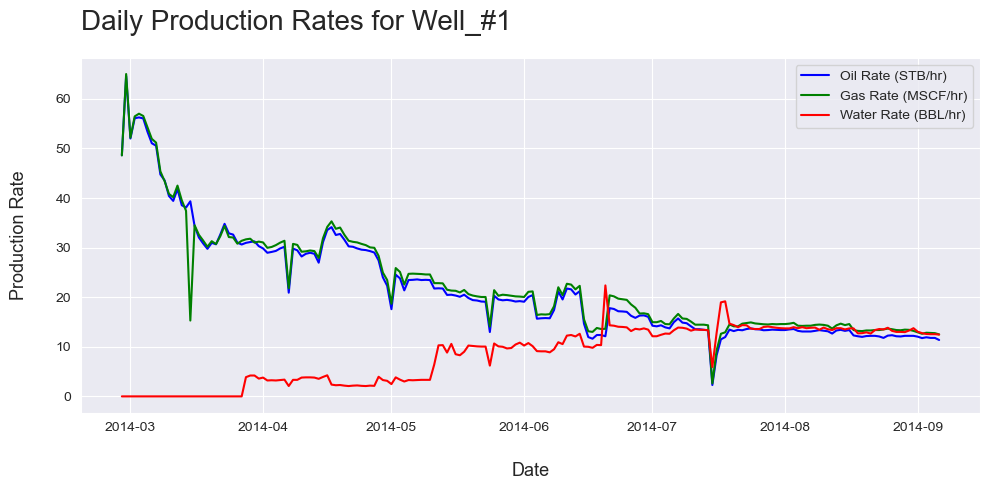

In [16]:
# Visualizing daily production rates for a sample well (e.g., Well_#1)
sample_well = 'Well_#1'
well_data = well_df[well_df['WELL_NAME'] == sample_well]
plt.figure(figsize=(10, 5))
plt.plot(well_data['PROD_DATE'], well_data['OIL_RATE'], label='Oil Rate (STB/hr)', color='blue')
plt.plot(well_data['PROD_DATE'], well_data['GAS_RATE'], label='Gas Rate (MSCF/hr)', color='green')
plt.plot(well_data['PROD_DATE'], well_data['WATER_RATE'], label='Water Rate (BBL/hr)', color='red')
plt.xlabel("Date", fontsize=13, labelpad=20)
plt.ylabel("Production Rate", fontsize=13, labelpad=20)
plt.title(f"Daily Production Rates for {sample_well}", fontsize=20, pad=20, loc="left")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('daily_production_well_1.png', dpi=300)
plt.show()

The plot shows oil rate declining steadily, water rate increasing gradually (suggesting an Increasing watercut trend for classification), and gas rate staying stable.

## Exploratory Data Analysis (EDA)

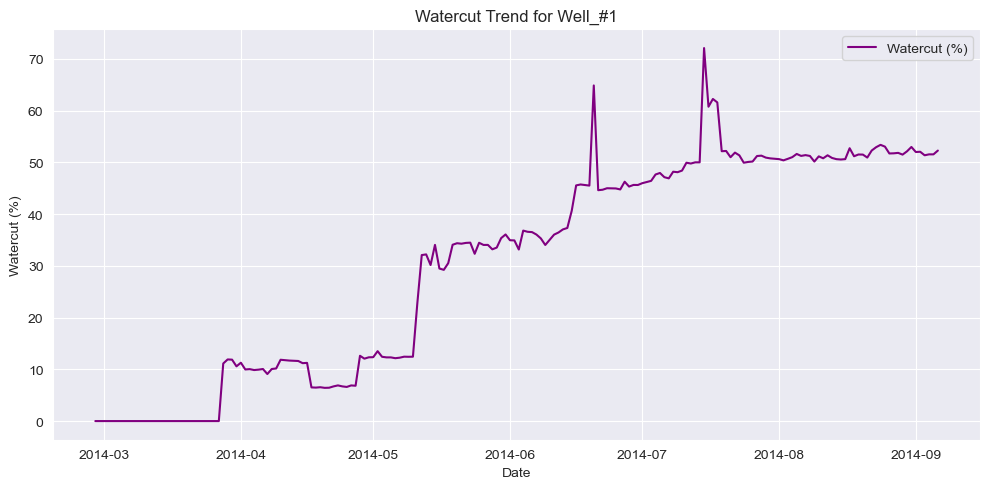

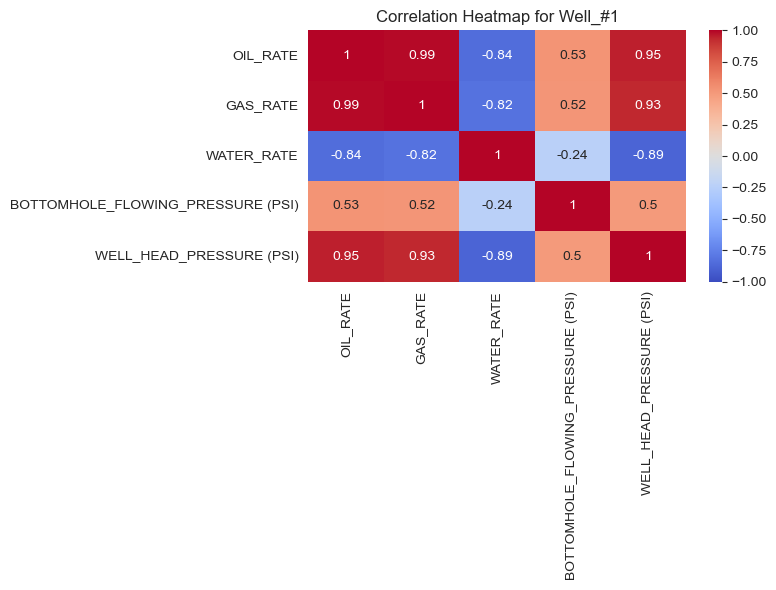

In [17]:
well_1_data = well_df[well_df['WELL_NAME'] == 'Well_#1'].copy()

# Calculate watercut (water rate / total fluid rate)
well_1_data['TOTAL_RATE'] = well_1_data['OIL_RATE'] + well_1_data['WATER_RATE']
well_1_data['WATERCUT'] = well_1_data['WATER_RATE'] / well_1_data['TOTAL_RATE'] * 100

# Plotting watercut over time
plt.figure(figsize=(10, 5))
plt.plot(well_1_data['PROD_DATE'], well_1_data['WATERCUT'], label='Watercut (%)', color='purple')
plt.xlabel("Date")
plt.ylabel("Watercut (%)")
plt.title("Watercut Trend for Well_#1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('watercut_trend_well_1.png', dpi=300)
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = well_1_data[['OIL_RATE', 'GAS_RATE', 'WATER_RATE', 'BOTTOMHOLE_FLOWING_PRESSURE (PSI)', 'WELL_HEAD_PRESSURE (PSI)']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap for Well_#1")
plt.tight_layout()
plt.savefig('correlation_heatmap_well_1.png', dpi=300)
plt.show()

Oil and gas rates are highly correlated (0.99), showing that they tend to increase together. Wellhead pressure shows a strong positive link with both oil (0.95) and gas (0.93) rates. Whereas, water rate has a strong negative correlation with oil (−0.84), gas (−0.82), and wellhead pressure (−0.89), meaning increased water typically leads to lower production and pressure. Lastly, bottomhole flowing pressure is averegely positive with oil (0.53) and gas (0.52) rates.

## FEATURE ENGINEERING

Adding new features (rolling averages, time-based variables, pressure ratio) to Well_#1 to enhance the dataset, supporting classification of the Increasing watercut trend

In [18]:
# Calculate time-based features
well_1_data['MONTH'] = well_1_data['PROD_DATE'].dt.month
well_1_data['YEAR'] = well_1_data['PROD_DATE'].dt.year
well_1_data['DAY_OF_YEAR'] = well_1_data['PROD_DATE'].dt.dayofyear

# Calculate rolling averages (30-day window) for rates
well_1_data['OIL_RATE_ROLLING'] = well_1_data['OIL_RATE'].rolling(window=30, min_periods=1).mean()
well_1_data['GAS_RATE_ROLLING'] = well_1_data['GAS_RATE'].rolling(window=30, min_periods=1).mean()
well_1_data['WATER_RATE_ROLLING'] = well_1_data['WATER_RATE'].rolling(window=30, min_periods=1).mean()

# Calculate watercut and its rolling average
well_1_data['TOTAL_RATE'] = well_1_data['OIL_RATE'] + well_1_data['WATER_RATE']
well_1_data['WATERCUT'] = well_1_data['WATER_RATE'] / well_1_data['TOTAL_RATE'] * 100
well_1_data['WATERCUT_ROLLING'] = well_1_data['WATERCUT'].rolling(window=30, min_periods=1).mean()

# Calculate pressure ratio
well_1_data['PRESSURE_RATIO'] = well_1_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] / well_1_data['WELL_HEAD_PRESSURE (PSI)']

# Drop rows with NaN values from rolling calculations
well_1_data = well_1_data.dropna()
well_1_data.to_csv('well_1_engineered.csv', index=False)

In [19]:
# Gas-Oil Ratio (GOR)
well_1_data['GOR'] = well_1_data['GAS_RATE'] / well_1_data['OIL_RATE']

# Productivity Index (PI)
well_1_data['PI'] = well_1_data['OIL_RATE'] / well_1_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)']

# Optional: Smooth with rolling average if noisy
well_1_data['GOR_ROLLING'] = well_1_data['GOR'].rolling(window=30, min_periods=1).mean()
well_1_data['PI_ROLLING'] = well_1_data['PI'].rolling(window=30, min_periods=1).mean()

# Drop any new NaNs
well_1_data = well_1_data.dropna()

# Save updated file
well_1_data.to_csv('well_1_features.csv', index=False)

Modeling for well 1 before scaliung up to the all wells

In [20]:
# Add your provided feature engineering
well_1_data['GOR'] = well_1_data['GAS_RATE'] / well_1_data['OIL_RATE']
well_1_data['PI'] = well_1_data['OIL_RATE'] / well_1_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)']
well_1_data['GOR_ROLLING'] = well_1_data['GOR'].rolling(window=30, min_periods=1).mean()
well_1_data['PI_ROLLING'] = well_1_data['PI'].rolling(window=30, min_periods=1).mean()

# Calculate existing features
well_1_data['TOTAL_RATE'] = well_1_data['OIL_RATE'] + well_1_data['WATER_RATE']
well_1_data['WATERCUT'] = well_1_data['WATER_RATE'] / well_1_data['TOTAL_RATE'] * 100
well_1_data['WATERCUT_ROLLING'] = well_1_data['WATERCUT'].rolling(window=30, min_periods=1).mean()
well_1_data['PRESSURE_RATIO'] = well_1_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] / well_1_data['WELL_HEAD_PRESSURE (PSI)']
well_1_data['MONTH'] = well_1_data['PROD_DATE'].dt.month
well_1_data['YEAR'] = well_1_data['PROD_DATE'].dt.year
well_1_data['DAY_OF_YEAR'] = well_1_data['PROD_DATE'].dt.dayofyear
well_1_data['OIL_RATE_ROLLING'] = well_1_data['OIL_RATE'].rolling(window=30, min_periods=1).mean()
well_1_data['GAS_RATE_ROLLING'] = well_1_data['GAS_RATE'].rolling(window=30, min_periods=1).mean()
well_1_data['WATER_RATE_ROLLING'] = well_1_data['WATER_RATE'].rolling(window=30, min_periods=1).mean()

# Define target: classify watercut trend
well_1_data['WATERCUT_DIFF'] = well_1_data['WATERCUT_ROLLING'].diff()
well_1_data['TARGET'] = (well_1_data['WATERCUT_DIFF'] > 0).astype(int).shift(-1)
well_1_data = well_1_data.dropna()

# Features and target
features = ['MONTH', 'YEAR', 'DAY_OF_YEAR', 'OIL_RATE_ROLLING', 'GAS_RATE_ROLLING', 
            'WATER_RATE_ROLLING', 'PRESSURE_RATIO', 'GOR_ROLLING', 'PI_ROLLING']
X = well_1_data[features]
y = well_1_data['TARGET']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(model, 'well_1_model.pkl')

Accuracy: 0.97

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        10
         1.0       0.97      1.00      0.98        28

    accuracy                           0.97        38
   macro avg       0.98      0.95      0.96        38
weighted avg       0.97      0.97      0.97        38



['well_1_model.pkl']

The Random Forest model, using all engineered features including GOR and PI, achieves an accuracy of 0.97 on Well_#1, effectively classifying the Increasing watercut trend.

## MODEL EVALUATION AND SCALING

In [21]:
all_wells_data = well_df.copy()

# Add feature engineering for all wells
all_wells_data['GOR'] = all_wells_data['GAS_RATE'] / all_wells_data['OIL_RATE']
all_wells_data['PI'] = all_wells_data['OIL_RATE'] / all_wells_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)']
all_wells_data['GOR_ROLLING'] = all_wells_data['GOR'].rolling(window=30, min_periods=1).mean()
all_wells_data['PI_ROLLING'] = all_wells_data['PI'].rolling(window=30, min_periods=1).mean()
all_wells_data['TOTAL_RATE'] = all_wells_data['OIL_RATE'] + all_wells_data['WATER_RATE']
all_wells_data['WATERCUT'] = all_wells_data['WATER_RATE'] / all_wells_data['TOTAL_RATE'] * 100
all_wells_data['WATERCUT_ROLLING'] = all_wells_data['WATERCUT'].rolling(window=30, min_periods=1).mean()
all_wells_data['PRESSURE_RATIO'] = all_wells_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] / all_wells_data['WELL_HEAD_PRESSURE (PSI)']
all_wells_data['MONTH'] = all_wells_data['PROD_DATE'].dt.month
all_wells_data['YEAR'] = all_wells_data['PROD_DATE'].dt.year
all_wells_data['DAY_OF_YEAR'] = all_wells_data['PROD_DATE'].dt.dayofyear
all_wells_data['OIL_RATE_ROLLING'] = all_wells_data['OIL_RATE'].rolling(window=30, min_periods=1).mean()
all_wells_data['GAS_RATE_ROLLING'] = all_wells_data['GAS_RATE'].rolling(window=30, min_periods=1).mean()
all_wells_data['WATER_RATE_ROLLING'] = all_wells_data['WATER_RATE'].rolling(window=30, min_periods=1).mean()

# Define target for all wells
all_wells_data['WATERCUT_DIFF'] = all_wells_data['WATERCUT_ROLLING'].diff()
all_wells_data['TARGET'] = (all_wells_data['WATERCUT_DIFF'] > 0).astype(int).shift(-1)
all_wells_data = all_wells_data.dropna()

# Features and target
features = ['MONTH', 'YEAR', 'DAY_OF_YEAR', 'OIL_RATE_ROLLING', 'GAS_RATE_ROLLING', 
            'WATER_RATE_ROLLING', 'PRESSURE_RATIO', 'GOR_ROLLING', 'PI_ROLLING']
X = all_wells_data[features]
y = all_wells_data['TARGET']

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load Well_#1 model and evaluate on all wells
model = joblib.load('well_1_model.pkl')
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on All Wells: {accuracy:.2f}")
print("\nClassification Report on All Wells:")
print(classification_report(y_test, y_pred))

# Save predictions for all wells
all_wells_data['PREDICTED_TREND'] = model.predict(X)
all_wells_data.to_csv('all_wells_predictions.csv', index=False)

Accuracy on All Wells: 0.47

Classification Report on All Wells:
              precision    recall  f1-score   support

         0.0       0.34      0.55      0.42       500
         1.0       0.63      0.42      0.50       902

    accuracy                           0.47      1402
   macro avg       0.49      0.49      0.46      1402
weighted avg       0.53      0.47      0.47      1402



In [ ]:
# Add feature engineering for all wells
all_wells_data['GOR'] = all_wells_data['GAS_RATE'] / all_wells_data['OIL_RATE']
all_wells_data['PI'] = all_wells_data['OIL_RATE'] / all_wells_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)']
all_wells_data['GOR_ROLLING'] = all_wells_data['GOR'].rolling(window=30, min_periods=1).mean()
all_wells_data['PI_ROLLING'] = all_wells_data['PI'].rolling(window=30, min_periods=1).mean()
all_wells_data['TOTAL_RATE'] = all_wells_data['OIL_RATE'] + all_wells_data['WATER_RATE']
all_wells_data['WATERCUT'] = all_wells_data['WATER_RATE'] / all_wells_data['TOTAL_RATE'] * 100
all_wells_data['WATERCUT_ROLLING'] = all_wells_data['WATERCUT'].rolling(window=30, min_periods=1).mean()
all_wells_data['PRESSURE_RATIO'] = all_wells_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] / all_wells_data['WELL_HEAD_PRESSURE (PSI)']
all_wells_data['MONTH'] = all_wells_data['PROD_DATE'].dt.month
all_wells_data['YEAR'] = all_wells_data['PROD_DATE'].dt.year
all_wells_data['DAY_OF_YEAR'] = all_wells_data['PROD_DATE'].dt.dayofyear
all_wells_data['OIL_RATE_ROLLING'] = all_wells_data['OIL_RATE'].rolling(window=30, min_periods=1).mean()
all_wells_data['GAS_RATE_ROLLING'] = all_wells_data['GAS_RATE'].rolling(window=30, min_periods=1).mean()
all_wells_data['WATER_RATE_ROLLING'] = all_wells_data['WATER_RATE'].rolling(window=30, min_periods=1).mean()

# Define target for all wells
all_wells_data['WATERCUT_DIFF'] = all_wells_data['WATERCUT_ROLLING'].diff()
all_wells_data['TARGET'] = (all_wells_data['WATERCUT_DIFF'] > 0).astype(int).shift(-1)
all_wells_data = all_wells_data.dropna()

# Features and target
features = ['MONTH', 'YEAR', 'DAY_OF_YEAR', 'OIL_RATE_ROLLING', 'GAS_RATE_ROLLING', 
            'WATER_RATE_ROLLING', 'PRESSURE_RATIO', 'GOR_ROLLING', 'PI_ROLLING']
X = all_wells_data[features]
y = all_wells_data['TARGET']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tune Random Forest model
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Predict and evaluate
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on All Wells: {accuracy:.2f}")
print("\nClassification Report on All Wells:")
print(classification_report(y_test, y_pred))

# Save predictions for all wells
all_wells_data['PREDICTED_TREND'] = best_model.predict(X)
all_wells_data.to_csv('all_wells_predictions.csv', index=False)

# Save tuned model
joblib.dump(best_model, 'best_all_wells_model.pkl')

In [ ]:
# Calculate rolling averages and other features
all_wells_data['GOR_ROLLING'] = all_wells_data['GOR'].rolling(window=30, min_periods=1).mean()
all_wells_data['PI_ROLLING'] = all_wells_data['PI'].rolling(window=30, min_periods=1).mean()
all_wells_data['WATERCUT_ROLLING'] = all_wells_data['WATERCUT'].rolling(window=30, min_periods=1).mean()
all_wells_data['PRESSURE_RATIO'] = np.where(all_wells_data['WELL_HEAD_PRESSURE (PSI)'] > 0, 
                                           all_wells_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] / all_wells_data['WELL_HEAD_PRESSURE (PSI)'], 0)
all_wells_data['MONTH'] = all_wells_data['PROD_DATE'].dt.month
all_wells_data['YEAR'] = all_wells_data['PROD_DATE'].dt.year
all_wells_data['DAY_OF_YEAR'] = all_wells_data['PROD_DATE'].dt.dayofyear
all_wells_data['OIL_RATE_ROLLING'] = all_wells_data['OIL_RATE'].rolling(window=30, min_periods=1).mean()
all_wells_data['GAS_RATE_ROLLING'] = all_wells_data['GAS_RATE'].rolling(window=30, min_periods=1).mean()
all_wells_data['WATER_RATE_ROLLING'] = all_wells_data['WATER_RATE'].rolling(window=30, min_periods=1).mean()

In [ ]:
# Preserve all wells with any data
all_wells_data = all_wells_data.groupby('WELL_NAME').filter(lambda x: not x.empty)

In [ ]:
# Define trends
all_wells_data['WATERCUT_DIFF'] = all_wells_data['WATERCUT_ROLLING'].diff()
all_wells_data['PI_DIFF'] = all_wells_data['PI_ROLLING'].diff()

In [ ]:
# Classify parameters functions
def classify_reservoir(well):
    max_bhp = well['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].max()
    best_match = None
    min_diff = 200  # Increased threshold to 500 PSI
    for _, row in reservoir_df.iterrows():
        res_pressure = row['Current Average Reservoir Pressure (PSI)']
        if pd.notna(res_pressure):
            diff = abs(max_bhp - res_pressure)
            if diff <= 500 and diff < min_diff:
                min_diff = diff
                best_match = row['Reservoir Name']
    if not best_match:
        print(f"No match for max BHP: {max_bhp}")
    return best_match if best_match else 'Unknown'

def classify_saturation(well, reservoir):
    if reservoir == 'Unknown':
        return 'Undetermined'
    res_data = reservoir_df[reservoir_df['Reservoir Name'] == reservoir].iloc[0]
    return 'Saturated' if res_data['Initial Reservoir Pressure (PSI)'] <= res_data['Bubble Point Pressure (PSI)'] else 'Undersaturated'

def classify_well_type(well):
    pressure_drop = well['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].max() - well['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].min()
    return 'GL' if pressure_drop > 1000 else 'NF'

def classify_production_type(well):
    oil_drop = well['OIL_RATE'].pct_change().abs().rolling(window=90).max()
    max_drop = oil_drop.max() if pd.notna(oil_drop).any() else 0
    return 'Unsteady' if max_drop > 0.5 else 'Steady'

def classify_gor_trend(well, reservoir):
    if reservoir == 'Unknown':
        return 'Undetermined'
    res_gor = reservoir_df[reservoir_df['Reservoir Name'] == reservoir]['Solution Gas-Oil-Ratio (SCF/BBL)'].iloc[0]
    avg_gor = well['GOR_ROLLING'].mean()
    return 'aSo/GOR' if pd.notna(avg_gor) and avg_gor > res_gor else 'bSo/GOR'

def classify_watercut_trend(well):
    watercut_trend = well['WATERCUT_DIFF'].mean()
    if pd.notna(watercut_trend):
        return 'Incr' if watercut_trend > 0 else 'Decr' if watercut_trend < 0 else 'Flat'
    return 'Flat'

def classify_pi_trend(well):
    pi_trend = well['PI_DIFF'].mean()
    if pd.notna(pi_trend):
        return 'Incr' if pi_trend > 0 else 'Decr' if pi_trend < 0 else 'Flat'
    return 'Flat'

# Validate columns
for col in ['WELL_NAME', 'BOTTOMHOLE_FLOWING_PRESSURE (PSI)', 'OIL_RATE', 'WATER_RATE', 'GAS_RATE',
            'WELL_HEAD_PRESSURE (PSI)', 'CUMULATIVE_OIL_PROD (STB)', 'PROD_DATE']:
    if col not in all_wells_data.columns:
        raise KeyError(f"Column '{col}' not found.")

In [ ]:
# Apply classifications to all unique wells
unique_wells = all_wells_data['WELL_NAME'].unique()
classifications = []
for well_name in unique_wells:
    group = all_wells_data[all_wells_data['WELL_NAME'] == well_name]
    reservoir = classify_reservoir(group)
    saturation = classify_saturation(group, reservoir)
    well_type = classify_well_type(group)
    prod_type = classify_production_type(group)
    gor_trend = classify_gor_trend(group, reservoir)
    watercut_trend = classify_watercut_trend(group)
    pi_trend = classify_pi_trend(group)
    classifications.append([well_name, reservoir, saturation, well_type, prod_type, gor_trend, watercut_trend, pi_trend])

print(f"Classified {len(classifications)} wells")

In [ ]:
# Create classification DataFrame
cols = ['WELL_NAME', 'Reservoir Name', 'Reservoir Type', 'Well Type', 'Production Type', 
        'Formation GOR Trend', 'Watercut Trend', 'Oil Productivity Index Trend']
classification_df = pd.DataFrame(classifications, columns=cols)

# Output to verify
print(classification_df.to_string())

In [ ]:
!git add .

In [ ]:
!git commit -m "Classification done, Not perfect yet though"

In [ ]:
!git push origin main